# Deterministic Linear Transport equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial r}{\partial t} + v\frac{\partial j}{\partial x} = \frac{\sigma(x, z)}{\epsilon^2}(\hat{r} - r), \\
&\frac{\partial j}{\partial t} + \frac{v}{\epsilon^2}\frac{\partial r}{\partial x} = - \frac{\sigma(x, z)}{\epsilon^2}j, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number, $v \in [-1, 1]$, and $\hat{r} = \int_{0}^{1} rdv$. 

It seems to me that $v$ follows a uniform distribution (as Gauss-Legendre quadrature is used to compute the integral).

We let $\sigma(x, z) \equiv 1$.

BC:
$$
r(0, t, v) = 1, \ r(1, t, v) = 0, \ j(0, t, v) = 0, j(1, t, v) = 0.
$$

IC:
$$
\begin{aligned}
&r(x, 0, v) = 1, \ 0 \le x < 0.5, \\
&r(x, 0, v) = 0, \ 0.5 \le x \le 1, \\
&j(x, 0, v) = 0.
\end{aligned}
$$

Domain:
$$
(x, t, v) \in [0, 1]\times [0, 0.01] \times [0, 1].
$$

In [1]:
NAME = "4_1e-8_dirichlet_bc_2"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [32]*4 + [2] # (x, t, v) -> (r, j)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_r, w_j)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[0., 0., 0.], [1., 0.01, 1.0]])

sigma = 1.0
epsilon = 1e-8

@jax.jit
def model(params, xtv): # for predictions
	# linear scaling
	xtv = (2*xtv - (domain[0, :]+domain[1, :]))/(domain[1, :] - domain[0, :])
	for w, b in params[:-1]:
		xtv = jnp.sin(jnp.dot(xtv, w) + b)
	return jnp.dot(xtv, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def quadrature(params, x, t, v, w):
	xt_ = jnp.repeat(jnp.hstack([x, t]), w.shape[0], axis = 0)
	v_ = jnp.tile(v, (x.shape[0], 1))
	rj = model(params, jnp.hstack([xt_, v_]))
	r = rj[:, 0:1].reshape((x.shape[0], w.shape[0]))
	return jnp.dot(r, w)

# jacobian[i] = [[dr/dx, dr/dt, dr/dv],
#                [dj/dx, dj/dt, dj/dv]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, bc, quad = batch["collocation"], batch["dirichlet"], batch["bc"], batch["quad"]
	direct_params = params
	
	if collocation[0] is not None:
		rj_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		r_c, j_c = rj_c[:, 0:1], rj_c[:, 1:2]
		drj_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		dr_dt_c, dj_dt_c = drj_dxtv_c[:, 0:1, 1], drj_dxtv_c[:, 1:2, 1]
		dr_dx_c, dj_dx_c = drj_dxtv_c[:, 0:1, 0], drj_dxtv_c[:, 1:2, 0]
		
		# quad.w: [q, 1]
		# quad.v: [q, 1]
		r_hat_c = quadrature(direct_params, collocation.x, collocation.t, quad.v, quad.w)
		
		loss_c1 = metaloss(epsilon**2*(dr_dt_c + collocation.v*dj_dx_c), sigma*(r_hat_c - r_c))
		loss_c2 = metaloss(epsilon**2*dj_dt_c + collocation.v*dr_dx_c, -sigma*j_c)
	else:
		loss_c1 = loss_c2 = 0
        
	if dirichlet[0] is not None:
		rj_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t, dirichlet.v]))
		r_d, j_d = rj_d[:, 0:1], rj_d[:, 1:2]
		loss_dr = metaloss(r_d, dirichlet.r)
		loss_dj = metaloss(j_d, dirichlet.j)
	else:
		loss_dr = loss_dj = 0.0
		
	if bc[0] is not None:
		rj_bl = model(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
		rj_br = model(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
		r_bl, j_bl = rj_bl[:, 0:1], rj_bl[:, 1:2]
		r_br, j_br = rj_br[:, 0:1], rj_br[:, 1:2]
		loss_bl = metaloss(r_bl, 1) + metaloss(j_bl, 0)
		loss_br = metaloss(r_br, 0) + metaloss(j_br, 0)

	return loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["dr"]*loss_dr + w["dj"]*loss_dj + w["bl"]*loss_bl + w["br"]*loss_br + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["dr"]*loss_dr + w["dj"]*loss_dj + w["bl"]*loss_bl + w["br"]*loss_br, \
			loss_c1, loss_c2, loss_dr, loss_dj, loss_bl, loss_br, l1, l2

In [5]:
r0_fn = lambda x, t, v: jnp.select([x < 0.5, x >= 0.5], [1.0, 0.0])
j0_fn = lambda x, t, v: jnp.zeros_like(x)

key, *subkeys = random.split(key, 3)

n_quad = 2
v_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)
v_quad = jnp.array(0.5*(v_quad+1), dtype = jnp.float32).reshape((-1, 1))
w_quad = jnp.array(0.5*w_quad, dtype = jnp.float32).reshape((-1, 1))

n_i = 200
x_i = jnp.linspace(*domain[:, 0], n_i)
v_i = v_quad
xv_i = tensor_grid([x_i, v_i])
x_i, v_i = xv_i[:, 0:1], xv_i[:, 1:2]
t_i = jnp.zeros_like(x_i)
r_i = r0_fn(x_i, t_i, v_i)
j_i = j0_fn(x_i, t_i, v_i)

n_b = 100
t_b = jnp.linspace(*domain[:, 1], n_b)
v_b = v_quad
tv_b = tensor_grid([t_b, v_b])
t_b, v_b = tv_b[:, 0:1], tv_b[:, 1:2]
x_bl = jnp.ones_like(t_b)*domain[0, 0]
x_br = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 200
n_ct = 200
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
v_c = v_quad
# n_cv = 200
# v_c = jnp.linspace(*domain[:, 2], n_cv).reshape((-1, 1))
xtv_c = tensor_grid([x_c, t_c, v_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "v", "r", "j"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t", "v"])
dataset_Quad = namedtuple("dataset_Quad", ["w", "v"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t", "v"])

dirichlet = dataset_Dirichlet(x_i, t_i, v_i, r_i, j_i)
collocation = dataset_Collocation(xtv_c[:, 0:1], xtv_c[:, 1:2], xtv_c[:, 2:3])
quad = dataset_Quad(w_quad, v_quad)
bc = dataset_BC(x_bl, x_br, t_b, v_b)

In [6]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 320, "collocation": 20000, "bc": 160}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], bc, batch_size["bc"])

start_iteration = 0
iterations = 50000
print_every = 100
save_every = 10000
weights = {"c1": 10.0, "c2": 1.0, "dr": 1.0, "dj": 1.0, "bl": 1.0, "br": 1.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "bl", "br", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
# 			"collocation": dataset_Collocation(*Collocation.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/28, 23:00:08, Iteration: 0, Train Loss: 1.8724e+00, c1: 1.0216e-02, c2: 1.2331e-01, dr: 5.0383e-01, dj: 6.4785e-02, bl: 9.1884e-01, br: 1.5947e-01, l1_reg: 3.0202e+02, l2_reg: 4.2663e+01
2020/08/28, 23:00:14, Iteration: 100, Train Loss: 7.7539e-01, c1: 2.0764e-03, c2: 4.8994e-01, dr: 2.4617e-01, dj: 5.8245e-04, bl: 8.6377e-03, br: 9.2980e-03, l1_reg: 3.0414e+02, l2_reg: 4.3157e+01
2020/08/28, 23:00:15, Iteration: 200, Train Loss: 7.5498e-01, c1: 6.9050e-04, c2: 4.9286e-01, dr: 2.4104e-01, dj: 1.6416e-03, bl: 8.9047e-03, br: 3.6336e-03, l1_reg: 3.0326e+02, l2_reg: 4.2881e+01
2020/08/28, 23:00:16, Iteration: 300, Train Loss: 7.5700e-01, c1: 1.6395e-03, c2: 4.9358e-01, dr: 2.3784e-01, dj: 3.5780e-04, bl: 5.5271e-03, br: 3.2994e-03, l1_reg: 3.0274e+02, l2_reg: 4.2773e+01
2020/08/28, 23:00:18, Iteration: 400, Train Loss: 7.6511e-01, c1: 2.1960e-03, c2: 5.0000e-01, dr: 2.3357e-01, dj: 5.0030e-04, bl: 4.7334e-03, br: 4.3506e-03, l1_reg: 3.0242e+02, l2_reg: 4.2769e+01
2020/08/28, 23:00

2020/08/28, 23:01:09, Iteration: 4200, Train Loss: 2.2560e-01, c1: 1.0072e-03, c2: 1.2787e-01, dr: 6.3733e-02, dj: 5.9023e-03, bl: 7.5693e-03, br: 1.0450e-02, l1_reg: 3.5577e+02, l2_reg: 6.8653e+01
2020/08/28, 23:01:10, Iteration: 4300, Train Loss: 2.1325e-01, c1: 9.1667e-04, c2: 1.2339e-01, dr: 6.1449e-02, dj: 6.1467e-03, bl: 7.0836e-03, br: 6.0104e-03, l1_reg: 3.5668e+02, l2_reg: 6.9158e+01
2020/08/28, 23:01:12, Iteration: 4400, Train Loss: 2.1530e-01, c1: 8.1629e-04, c2: 1.1953e-01, dr: 5.9877e-02, dj: 7.6687e-03, bl: 1.2074e-02, br: 7.9867e-03, l1_reg: 3.5759e+02, l2_reg: 6.9652e+01
2020/08/28, 23:01:13, Iteration: 4500, Train Loss: 1.9699e-01, c1: 6.4911e-04, c2: 1.0923e-01, dr: 5.9118e-02, dj: 4.6972e-03, bl: 1.1193e-02, br: 6.2618e-03, l1_reg: 3.5853e+02, l2_reg: 7.0178e+01
2020/08/28, 23:01:14, Iteration: 4600, Train Loss: 2.0739e-01, c1: 1.4168e-03, c2: 1.1101e-01, dr: 5.7425e-02, dj: 6.4445e-03, bl: 6.1100e-03, br: 1.2224e-02, l1_reg: 3.5946e+02, l2_reg: 7.0708e+01
2020/08/28

2020/08/28, 23:02:05, Iteration: 8400, Train Loss: 1.1610e-01, c1: 4.7371e-04, c2: 6.4311e-02, dr: 3.5383e-02, dj: 3.1189e-03, bl: 3.3418e-03, br: 5.2032e-03, l1_reg: 3.7958e+02, l2_reg: 8.1403e+01
2020/08/28, 23:02:06, Iteration: 8500, Train Loss: 1.2588e-01, c1: 4.7354e-04, c2: 6.4966e-02, dr: 3.5628e-02, dj: 3.9570e-03, bl: 1.0709e-02, br: 5.8812e-03, l1_reg: 3.8004e+02, l2_reg: 8.1676e+01
2020/08/28, 23:02:08, Iteration: 8600, Train Loss: 1.2567e-01, c1: 4.0856e-04, c2: 6.6699e-02, dr: 3.5076e-02, dj: 4.8404e-03, bl: 8.6233e-03, br: 6.3466e-03, l1_reg: 3.8051e+02, l2_reg: 8.1955e+01
2020/08/28, 23:02:09, Iteration: 8700, Train Loss: 1.3112e-01, c1: 1.1177e-03, c2: 6.2831e-02, dr: 3.4970e-02, dj: 5.9779e-03, bl: 1.2117e-02, br: 4.0437e-03, l1_reg: 3.8098e+02, l2_reg: 8.2241e+01
2020/08/28, 23:02:11, Iteration: 8800, Train Loss: 1.2094e-01, c1: 5.0141e-04, c2: 6.1924e-02, dr: 3.4084e-02, dj: 7.5756e-03, bl: 7.6213e-03, br: 4.7194e-03, l1_reg: 3.8145e+02, l2_reg: 8.2513e+01
2020/08/28

2020/08/28, 23:03:01, Iteration: 12600, Train Loss: 9.9945e-02, c1: 3.9547e-04, c2: 4.9930e-02, dr: 2.8403e-02, dj: 6.4430e-03, bl: 4.7537e-03, br: 6.4607e-03, l1_reg: 3.9343e+02, l2_reg: 8.9809e+01
2020/08/28, 23:03:03, Iteration: 12700, Train Loss: 9.9401e-02, c1: 6.1682e-04, c2: 5.1253e-02, dr: 2.7756e-02, dj: 3.2791e-03, bl: 4.4859e-03, br: 6.4584e-03, l1_reg: 3.9367e+02, l2_reg: 8.9959e+01
2020/08/28, 23:03:04, Iteration: 12800, Train Loss: 1.0033e-01, c1: 4.1738e-04, c2: 4.9543e-02, dr: 2.8174e-02, dj: 4.7090e-03, bl: 7.8380e-03, br: 5.8891e-03, l1_reg: 3.9384e+02, l2_reg: 9.0083e+01
2020/08/28, 23:03:05, Iteration: 12900, Train Loss: 9.4095e-02, c1: 5.1021e-04, c2: 4.4406e-02, dr: 2.7675e-02, dj: 3.7895e-03, bl: 4.8432e-03, br: 8.2794e-03, l1_reg: 3.9405e+02, l2_reg: 9.0233e+01
2020/08/28, 23:03:07, Iteration: 13000, Train Loss: 9.0393e-02, c1: 3.4369e-04, c2: 4.7733e-02, dr: 2.7688e-02, dj: 2.9638e-03, bl: 3.3192e-03, br: 5.2524e-03, l1_reg: 3.9426e+02, l2_reg: 9.0387e+01
2020/

2020/08/28, 23:03:57, Iteration: 16800, Train Loss: 7.5059e-02, c1: 4.8736e-04, c2: 3.9367e-02, dr: 2.3888e-02, dj: 2.7095e-03, bl: 1.6182e-03, br: 2.6021e-03, l1_reg: 4.0125e+02, l2_reg: 9.5440e+01
2020/08/28, 23:03:59, Iteration: 16900, Train Loss: 1.0238e-01, c1: 7.1973e-04, c2: 4.6805e-02, dr: 2.4585e-02, dj: 6.7199e-03, bl: 1.1384e-02, br: 5.6921e-03, l1_reg: 4.0143e+02, l2_reg: 9.5559e+01
2020/08/28, 23:04:00, Iteration: 17000, Train Loss: 8.7576e-02, c1: 2.6870e-04, c2: 4.3810e-02, dr: 2.4155e-02, dj: 5.0664e-03, bl: 6.2415e-03, br: 5.6147e-03, l1_reg: 4.0161e+02, l2_reg: 9.5682e+01
2020/08/28, 23:04:01, Iteration: 17100, Train Loss: 8.5944e-02, c1: 2.6945e-04, c2: 4.0734e-02, dr: 2.4764e-02, dj: 4.7178e-03, bl: 8.4830e-03, br: 4.5507e-03, l1_reg: 4.0179e+02, l2_reg: 9.5815e+01
2020/08/28, 23:04:03, Iteration: 17200, Train Loss: 1.0462e-01, c1: 4.1815e-04, c2: 4.6332e-02, dr: 2.4632e-02, dj: 9.5582e-03, bl: 1.4203e-02, br: 5.7175e-03, l1_reg: 4.0197e+02, l2_reg: 9.5933e+01
2020/

2020/08/28, 23:04:53, Iteration: 21000, Train Loss: 7.4789e-02, c1: 3.2621e-04, c2: 3.6862e-02, dr: 2.0550e-02, dj: 6.0568e-03, bl: 5.7109e-03, br: 2.3477e-03, l1_reg: 4.0792e+02, l2_reg: 1.0032e+02
2020/08/28, 23:04:54, Iteration: 21100, Train Loss: 8.6814e-02, c1: 2.4530e-04, c2: 3.9963e-02, dr: 2.1583e-02, dj: 4.6973e-03, bl: 8.3303e-03, br: 9.7878e-03, l1_reg: 4.0807e+02, l2_reg: 1.0042e+02
2020/08/28, 23:04:56, Iteration: 21200, Train Loss: 8.2564e-02, c1: 8.7591e-04, c2: 4.0516e-02, dr: 2.1879e-02, dj: 3.6833e-03, bl: 4.3253e-03, br: 3.4007e-03, l1_reg: 4.0822e+02, l2_reg: 1.0054e+02
2020/08/28, 23:04:57, Iteration: 21300, Train Loss: 8.1916e-02, c1: 3.2510e-04, c2: 4.0909e-02, dr: 2.0964e-02, dj: 4.9513e-03, bl: 6.9986e-03, br: 4.8420e-03, l1_reg: 4.0838e+02, l2_reg: 1.0065e+02
2020/08/28, 23:04:58, Iteration: 21400, Train Loss: 8.5555e-02, c1: 5.1421e-04, c2: 4.2036e-02, dr: 2.0433e-02, dj: 7.1092e-03, bl: 6.0002e-03, br: 4.8348e-03, l1_reg: 4.0857e+02, l2_reg: 1.0077e+02
2020/

2020/08/28, 23:05:49, Iteration: 25200, Train Loss: 6.7641e-02, c1: 4.4760e-04, c2: 3.4209e-02, dr: 1.9112e-02, dj: 2.6212e-03, bl: 2.7321e-03, br: 4.4903e-03, l1_reg: 4.1448e+02, l2_reg: 1.0487e+02
2020/08/28, 23:05:51, Iteration: 25300, Train Loss: 7.1498e-02, c1: 6.0356e-04, c2: 3.5293e-02, dr: 1.8380e-02, dj: 3.1328e-03, bl: 2.7775e-03, br: 5.8790e-03, l1_reg: 4.1463e+02, l2_reg: 1.0497e+02
2020/08/28, 23:05:52, Iteration: 25400, Train Loss: 7.5327e-02, c1: 3.6515e-04, c2: 3.5822e-02, dr: 1.9024e-02, dj: 5.7274e-03, bl: 6.2891e-03, br: 4.8125e-03, l1_reg: 4.1479e+02, l2_reg: 1.0507e+02
2020/08/28, 23:05:53, Iteration: 25500, Train Loss: 7.7661e-02, c1: 4.5143e-04, c2: 3.7414e-02, dr: 1.9851e-02, dj: 4.4084e-03, bl: 5.3351e-03, br: 6.1375e-03, l1_reg: 4.1494e+02, l2_reg: 1.0518e+02
2020/08/28, 23:05:55, Iteration: 25600, Train Loss: 7.0446e-02, c1: 2.8739e-04, c2: 3.5320e-02, dr: 1.8555e-02, dj: 3.9212e-03, bl: 4.3650e-03, br: 5.4106e-03, l1_reg: 4.1507e+02, l2_reg: 1.0528e+02
2020/

2020/08/28, 23:06:45, Iteration: 29400, Train Loss: 6.9885e-02, c1: 3.4711e-04, c2: 3.3649e-02, dr: 1.7726e-02, dj: 6.6439e-03, bl: 3.9744e-03, br: 4.4207e-03, l1_reg: 4.2043e+02, l2_reg: 1.0923e+02
2020/08/28, 23:06:47, Iteration: 29500, Train Loss: 7.4251e-02, c1: 5.5665e-04, c2: 3.1752e-02, dr: 1.8029e-02, dj: 7.2793e-03, bl: 9.1266e-03, br: 2.4973e-03, l1_reg: 4.2058e+02, l2_reg: 1.0933e+02
2020/08/28, 23:06:48, Iteration: 29600, Train Loss: 7.0437e-02, c1: 2.7067e-04, c2: 3.3179e-02, dr: 1.7566e-02, dj: 4.1645e-03, bl: 6.0073e-03, br: 6.8136e-03, l1_reg: 4.2070e+02, l2_reg: 1.0943e+02
2020/08/28, 23:06:49, Iteration: 29700, Train Loss: 6.2286e-02, c1: 2.6401e-04, c2: 3.1446e-02, dr: 1.7338e-02, dj: 4.6307e-03, bl: 3.6324e-03, br: 2.5993e-03, l1_reg: 4.2084e+02, l2_reg: 1.0953e+02
2020/08/28, 23:06:51, Iteration: 29800, Train Loss: 6.9773e-02, c1: 5.0362e-04, c2: 3.3589e-02, dr: 1.7970e-02, dj: 4.1033e-03, bl: 5.0877e-03, br: 3.9864e-03, l1_reg: 4.2101e+02, l2_reg: 1.0964e+02
2020/

2020/08/28, 23:07:41, Iteration: 33600, Train Loss: 5.9308e-02, c1: 2.2604e-04, c2: 2.7010e-02, dr: 1.6365e-02, dj: 4.9011e-03, bl: 5.4613e-03, br: 3.3108e-03, l1_reg: 4.2656e+02, l2_reg: 1.1344e+02
2020/08/28, 23:07:43, Iteration: 33700, Train Loss: 5.9076e-02, c1: 3.3868e-04, c2: 3.1590e-02, dr: 1.5754e-02, dj: 3.4001e-03, bl: 1.5148e-03, br: 3.4299e-03, l1_reg: 4.2668e+02, l2_reg: 1.1353e+02
2020/08/28, 23:07:44, Iteration: 33800, Train Loss: 7.3675e-02, c1: 2.9513e-04, c2: 3.5274e-02, dr: 1.7603e-02, dj: 4.9982e-03, bl: 5.7727e-03, br: 7.0767e-03, l1_reg: 4.2680e+02, l2_reg: 1.1361e+02
2020/08/28, 23:07:45, Iteration: 33900, Train Loss: 5.9162e-02, c1: 4.2012e-04, c2: 2.9659e-02, dr: 1.6046e-02, dj: 3.3146e-03, bl: 2.2518e-03, br: 3.6894e-03, l1_reg: 4.2695e+02, l2_reg: 1.1372e+02
2020/08/28, 23:07:46, Iteration: 34000, Train Loss: 5.7849e-02, c1: 2.4333e-04, c2: 3.1122e-02, dr: 1.5749e-02, dj: 2.7011e-03, bl: 1.4498e-03, br: 4.3945e-03, l1_reg: 4.2711e+02, l2_reg: 1.1382e+02
2020/

2020/08/28, 23:08:37, Iteration: 37800, Train Loss: 6.3202e-02, c1: 2.1638e-04, c2: 3.2405e-02, dr: 1.5916e-02, dj: 3.5013e-03, bl: 4.2694e-03, br: 4.9455e-03, l1_reg: 4.3186e+02, l2_reg: 1.1738e+02
2020/08/28, 23:08:38, Iteration: 37900, Train Loss: 5.4920e-02, c1: 3.3561e-04, c2: 2.4028e-02, dr: 1.6588e-02, dj: 5.1372e-03, bl: 2.7237e-03, br: 3.0871e-03, l1_reg: 4.3203e+02, l2_reg: 1.1748e+02
2020/08/28, 23:08:40, Iteration: 38000, Train Loss: 6.8369e-02, c1: 3.3868e-04, c2: 2.9951e-02, dr: 1.6106e-02, dj: 5.9063e-03, bl: 8.3642e-03, br: 4.6548e-03, l1_reg: 4.3218e+02, l2_reg: 1.1759e+02
2020/08/28, 23:08:41, Iteration: 38100, Train Loss: 6.0989e-02, c1: 3.7888e-04, c2: 2.8949e-02, dr: 1.4957e-02, dj: 4.0933e-03, bl: 4.7177e-03, br: 4.4839e-03, l1_reg: 4.3225e+02, l2_reg: 1.1766e+02
2020/08/28, 23:08:42, Iteration: 38200, Train Loss: 5.8213e-02, c1: 2.3201e-04, c2: 2.7387e-02, dr: 1.5085e-02, dj: 5.2732e-03, bl: 4.7583e-03, br: 3.3899e-03, l1_reg: 4.3239e+02, l2_reg: 1.1776e+02
2020/

2020/08/28, 23:09:33, Iteration: 42000, Train Loss: 6.1353e-02, c1: 3.3165e-04, c2: 2.6224e-02, dr: 1.4129e-02, dj: 6.7882e-03, bl: 4.8932e-03, br: 6.0023e-03, l1_reg: 4.3706e+02, l2_reg: 1.2143e+02
2020/08/28, 23:09:34, Iteration: 42100, Train Loss: 6.1286e-02, c1: 3.9135e-04, c2: 2.8102e-02, dr: 1.5215e-02, dj: 7.2867e-03, bl: 2.9824e-03, br: 3.7859e-03, l1_reg: 4.3715e+02, l2_reg: 1.2152e+02
2020/08/28, 23:09:36, Iteration: 42200, Train Loss: 5.2806e-02, c1: 3.1990e-04, c2: 2.6531e-02, dr: 1.4217e-02, dj: 5.1555e-03, bl: 1.6576e-03, br: 2.0461e-03, l1_reg: 4.3728e+02, l2_reg: 1.2163e+02
2020/08/28, 23:09:37, Iteration: 42300, Train Loss: 5.5789e-02, c1: 2.6436e-04, c2: 2.9207e-02, dr: 1.3822e-02, dj: 3.2985e-03, bl: 2.3165e-03, br: 4.5015e-03, l1_reg: 4.3742e+02, l2_reg: 1.2173e+02
2020/08/28, 23:09:38, Iteration: 42400, Train Loss: 6.3725e-02, c1: 3.5425e-04, c2: 2.7947e-02, dr: 1.5441e-02, dj: 6.2985e-03, bl: 3.0277e-03, br: 7.4682e-03, l1_reg: 4.3751e+02, l2_reg: 1.2182e+02
2020/

2020/08/28, 23:10:29, Iteration: 46200, Train Loss: 5.2217e-02, c1: 4.2473e-04, c2: 2.5626e-02, dr: 1.2878e-02, dj: 2.1994e-03, bl: 4.5803e-03, br: 2.6853e-03, l1_reg: 4.4163e+02, l2_reg: 1.2557e+02
2020/08/28, 23:10:30, Iteration: 46300, Train Loss: 4.7860e-02, c1: 1.9658e-04, c2: 2.2150e-02, dr: 1.3457e-02, dj: 5.4614e-03, bl: 1.3682e-03, br: 3.4574e-03, l1_reg: 4.4172e+02, l2_reg: 1.2566e+02
2020/08/28, 23:10:31, Iteration: 46400, Train Loss: 5.5862e-02, c1: 2.8874e-04, c2: 2.6566e-02, dr: 1.3763e-02, dj: 5.2304e-03, bl: 5.1056e-03, br: 2.3102e-03, l1_reg: 4.4183e+02, l2_reg: 1.2577e+02
2020/08/28, 23:10:33, Iteration: 46500, Train Loss: 4.8596e-02, c1: 2.0705e-04, c2: 2.4424e-02, dr: 1.2940e-02, dj: 2.4743e-03, bl: 3.6405e-03, br: 3.0466e-03, l1_reg: 4.4191e+02, l2_reg: 1.2586e+02
2020/08/28, 23:10:34, Iteration: 46600, Train Loss: 5.4658e-02, c1: 2.6010e-04, c2: 2.8597e-02, dr: 1.2722e-02, dj: 2.9188e-03, bl: 4.7584e-03, br: 3.0605e-03, l1_reg: 4.4203e+02, l2_reg: 1.2596e+02
2020/

In [51]:
from scipy.io import loadmat
params_ = get_params(opt_state)

data_true = loadmat("4_snapshots_epsilon_1e-8.mat")
x_test = data_true["x"]
t_test = data_true["times"][0]
r_hat_trues = data_true["rhos"].T

# x_test = jnp.linspace(*domain[:, 0], 200)
# t_test = jnp.linspace(*domain[:, 1], 2000)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]

r_hat_preds = [quadrature(params_, xt[:, 0:1], xt[:, 1:2], quad.v, quad.w) for xt in xt_tests]
# uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
# u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
# duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
# du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
# du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]

<IPython.core.display.Javascript object>


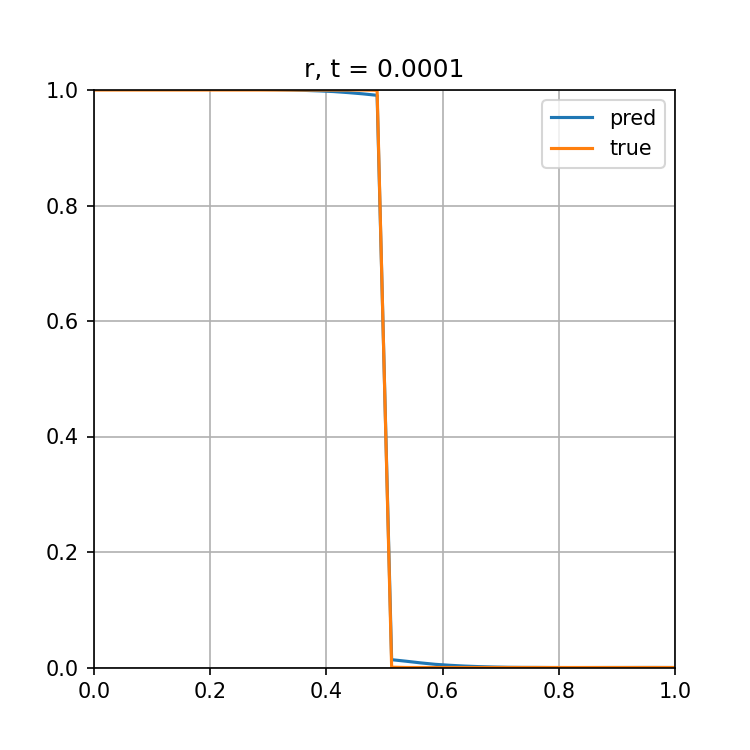

In [52]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
line1, = ax.plot([], [], lw = 1.5, label = "pred")
line2, = ax.plot([], [], lw = 1.5, label = "true")
lines = [line1, line2]
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()
ax.grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	r_hat_pred = r_hat_preds[i]
	r_hat_true = r_hat_trues[i]
	lines[0].set_data(x_test, r_hat_pred)
	lines[1].set_data(x_test, r_hat_true)
	ax.set_title("r, t = {:.4f}".format(t_test[i]))
	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>


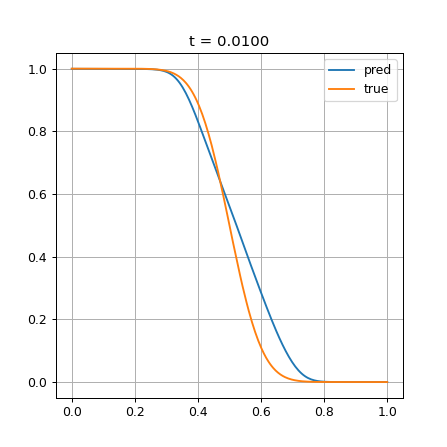

In [34]:
from scipy.io import loadmat
data = loadmat("4_epsilon_1e-8.mat")
x_true_, u_true = data["x"], data["u"]
x_true = np.zeros_like(u_true)
x_true[0] = 0; x_true[-1] = 1
x_true[1:-1] = x_true_

f, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(x_test, r_hat_preds[-1], label = "pred")
ax.plot(x_true, u_true, label = "true")
ax.set_title("t = {:.4f}".format(t_test[-1]))
ax.legend()
ax.grid()
plt.show()

In [ ]:
# from matplotlib import animation
# %matplotlib notebook

# fig, ax = plt.subplots(2, 3, figsize = (15, 10))
# lines = []
# for i in range(2):
# 	for j in range(3):
# 		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
# 		lines.append(line)
# 		ax[i][j].set_xlim([-1, 1])
# 		ax[i][j].set_ylim([-5, 5])
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# ax[0][0].set_ylim([0.9, 2.1])
# ax[1][0].set_ylim([-0.1, 1.0])
    
# def init():
# 	for line in lines:
# 		line.set_data([], [])
# 	return lines

# def animate(i):
# 	u_pred, v_pred = u_preds[i], v_preds[i]
# 	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
# 	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# # 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
# 	lines[0].set_data(x_test, u_pred)
# 	ax[0][0].set_title("u, t = {:.4f}".format(t_test[i]))
# 	lines[1].set_data(x_test, du_dx_pred)
# 	ax[0][1].set_title("du_dx, t = {:.4f}".format(t_test[i]))
# 	lines[2].set_data(x_test, du_dt_pred)
# 	ax[0][2].set_title("du_dt, t = {:.4f}".format(t_test[i]))
    
# 	lines[3].set_data(x_test, v_pred)
# 	ax[1][0].set_title("v, t = {:.4f}".format(t_test[i]))
# 	lines[4].set_data(x_test, dv_dx_pred)
# 	ax[1][1].set_title("dv_dx, t = {:.4f}".format(t_test[i]))
# 	lines[5].set_data(x_test, dv_dt_pred)
# 	ax[1][2].set_title("dv_dt, t = {:.4f}".format(t_test[i]))

# 	return lines

# anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
# plt.show()

In [ ]:
# from scipy.io import loadmat
# data = loadmat("epsilon_0.49.mat")
# x_true, u_true, v_true = data["x"], data["u"], data["v"]

# f, ax = plt.subplots(1, 2, figsize = (12, 5))
# ax[0].plot(x_test, u_preds[-1], label = "pred")
# ax[0].plot(x_true, u_true, label = "true")
# ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
# ax[1].plot(x_test, v_preds[-1], label = "pred")
# ax[1].plot(x_true, v_true, label = "true")
# ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
# for i in range(2):
# 	ax[i].legend()
# 	ax[i].grid()
# plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))